# Demo - RBIG

This is a tldr demonstration for how we can use RBIG to Gaussianize multivariate data, estimate probabilities and draw samples from our distribution.

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))


# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.models.rbig import IterativeGaussianization

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

We are going to generate a 2D dataset and plot the joint distribution.

<Figure size 432x288 with 0 Axes>

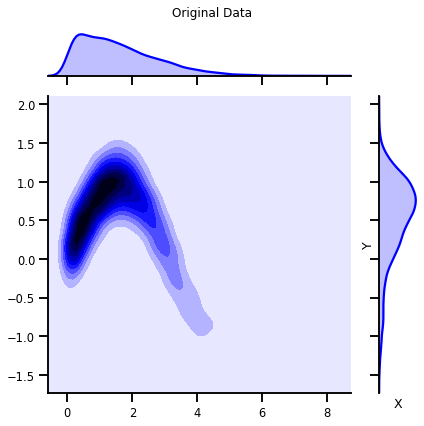

In [2]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

You can clearly see that this is not Gaussian; neither jointly nor marginally. Our objective is to use the RBIG algorithm to make this density jointly Gaussian or Gaussian.

### RBIG Object

RBIG works very similarly as an scikit-learn function. Meaning it follows the standard `transform`, `inverse_transform`, `predict_proba` and `score`.

In [70]:
from rbig_jax.models.rbig import RBIGStandard
# intialize Gaussianization transformation
data = get_classic(1_000)
max_layers = 15

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

In [71]:
%%time

# fit rbig model
Xtrans = rbig_clf.fit_transform(data)

# check layers are the same
assert rbig_clf.n_layers == max_layers

CPU times: user 2.94 s, sys: 9.74 ms, total: 2.95 s
Wall time: 2.92 s


In [72]:
%%time

# forward transformation
X_trans = rbig_clf.transform(data)


CPU times: user 333 ms, sys: 8.68 ms, total: 342 ms
Wall time: 327 ms


<Figure size 432x288 with 0 Axes>

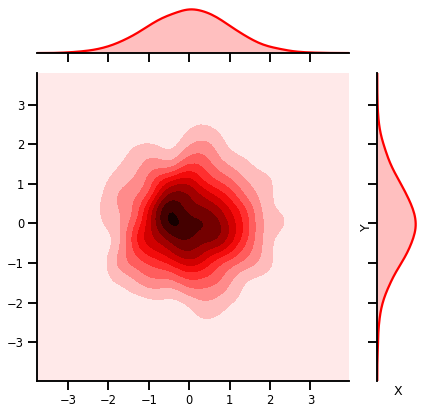

In [73]:
# plot results
plot_joint(X_trans, kind="kde")

Now our data is perfectly Gaussian. This means we can sample and we can also get probability estimates.

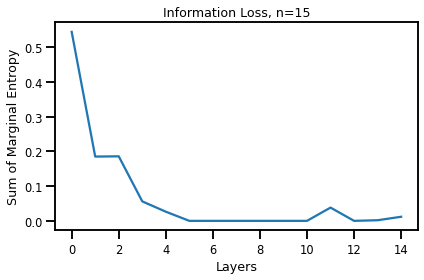

In [8]:
plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

### Density Estimation

In [9]:
%%time 

# inverse transform
X_lprob = rbig_clf.score_samples(data)

CPU times: user 987 ms, sys: 50.7 ms, total: 1.04 s
Wall time: 801 ms


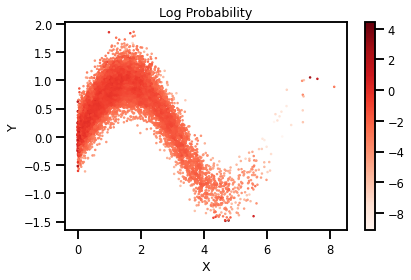

In [10]:
cmap = "Reds"
probs = X_lprob
# probs = np.clip(probs, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

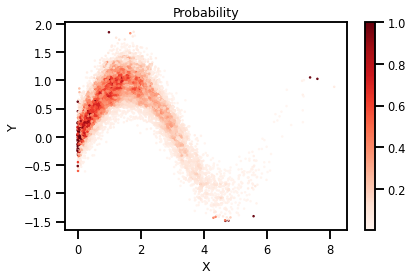

In [11]:
cmap = "Reds"
probs = np.exp(X_lprob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

## Two Moons Example

<Figure size 432x288 with 0 Axes>

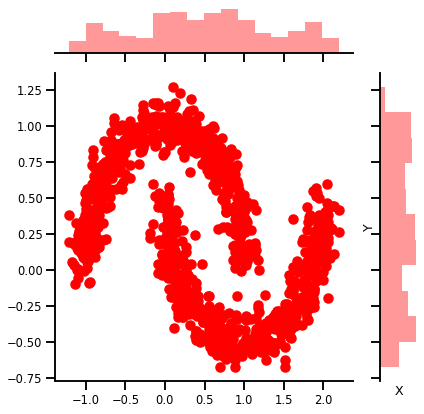

In [87]:
from sklearn import datasets as datasets

data, _ = datasets.make_moons(1_000, noise=.1)

plot_joint(data, kind="scatter")

In [77]:
%%time
# intialize Gaussianization transformation
max_layers = 12

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

# fit rbig model
Xtrans = rbig_clf.fit_transform(data)

CPU times: user 2.93 s, sys: 9.27 ms, total: 2.94 s
Wall time: 2.91 s


<Figure size 432x288 with 0 Axes>

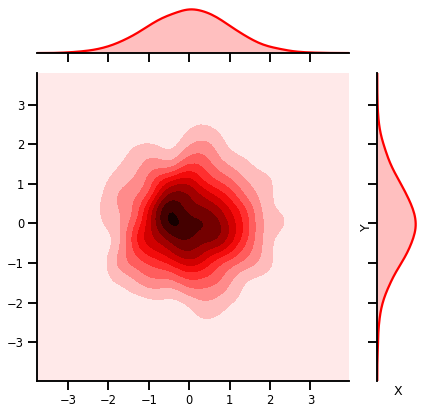

In [78]:
# plot results
plot_joint(X_trans, kind="kde")

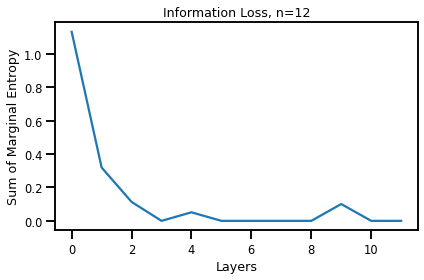

In [79]:
# plot results
plot_joint(X_trans, kind="kde")

plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

In [83]:
ngrid = 100
xline = np.linspace(-1.5, 2.5, ngrid)
yline = np.linspace(-.75, 1.25, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [84]:
%%time

# inverse transform
X_lprob = rbig_clf.score_samples(xyinput)

CPU times: user 39.1 ms, sys: 4.52 ms, total: 43.7 ms
Wall time: 13.9 ms


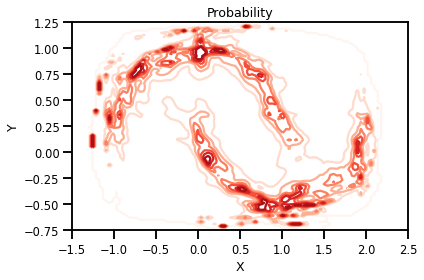

In [85]:

cmap = "Reds"
probs = np.exp(X_lprob).reshape(ngrid, ngrid)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.contour(xgrid, ygrid, probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_title(title)
plt.tight_layout()

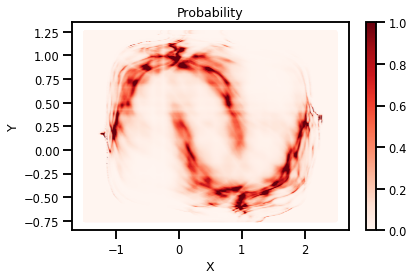

In [68]:
cmap = "Reds"
probs = np.exp(X_lprob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

## Circles

<Figure size 432x288 with 0 Axes>

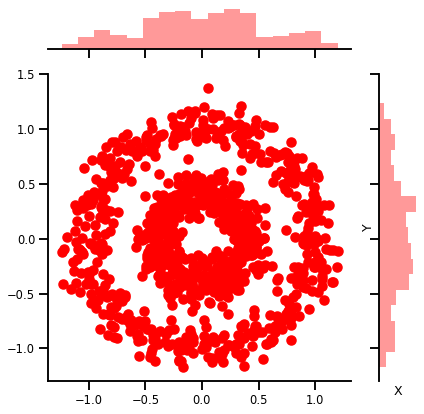

In [94]:
from sklearn import datasets as datasets

data, _ = datasets.make_circles(1_000, factor=0.4, noise=.1)

plot_joint(data, kind="scatter")

In [96]:
%%time
# intialize Gaussianization transformation
max_layers = 12

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

# fit rbig model
Xtrans = rbig_clf.fit_transform(data)

CPU times: user 2.94 s, sys: 33 ms, total: 2.97 s
Wall time: 2.92 s


<Figure size 432x288 with 0 Axes>

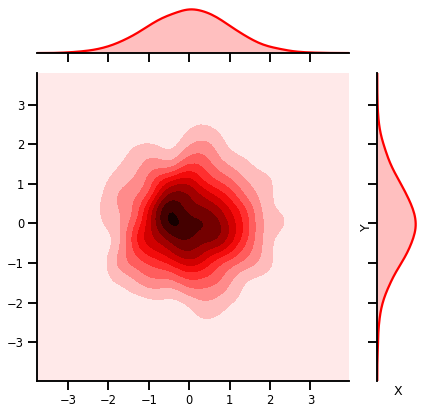

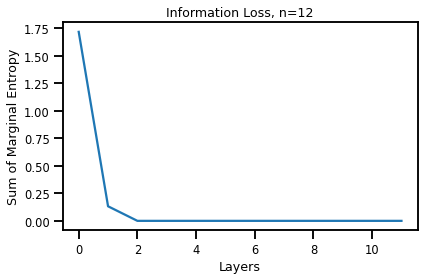

In [97]:
# plot results
plot_joint(X_trans, kind="kde")

plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

In [98]:
ngrid = 100
xline = np.linspace(-1.5, 2.5, ngrid)
yline = np.linspace(-.75, 1.25, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [99]:
%%time

# inverse transform
X_lprob = rbig_clf.score_samples(data)

CPU times: user 807 ms, sys: 9.52 ms, total: 817 ms
Wall time: 788 ms


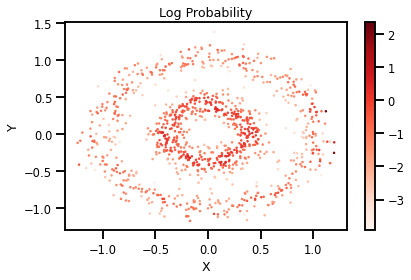

In [100]:
cmap = "Reds"
probs = X_lprob
# probs = np.clip(probs, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

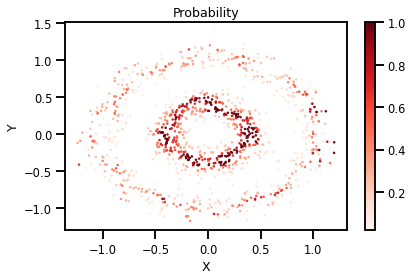

In [101]:
cmap = "Reds"
probs = np.exp(X_lprob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()